In [6]:
!pip install pyannote.audio
!pip install openai-whisper

  Obtaining dependency information for pyannote.audio from https://files.pythonhosted.org/packages/ec/05/46bf2216c6f89ab8f0b0c1be3a7f34808ae105df86ca682d2c040a0b5cb4/pyannote.audio-3.0.1-py2.py3-none-any.whl.metadata
  Using cached asteroid_filterbanks-0.4.0-py3-none-any.whl (29 kB)
  Obtaining dependency information for lightning>=2.0.1 from https://files.pythonhosted.org/packages/08/c7/8c33e2660161a99923fa9b46c72c31884efd482b89f7ead970cee5c0072a/lightning-2.1.0-py3-none-any.whl.metadata
  Using cached lightning-2.1.0-py3-none-any.whl.metadata (64 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
INFO: pip is looking at multiple versions of pyannote-audio to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for pyannote.audio from https://files.pythonhosted.org/packages/b0/8e/2b74f4fdfc0666f0e3acbe526c5ab0323b098f6edbbebcc9fb21bf806c60/pyannote.audio-3.0.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━

![Screenshot 2023-11-01 at 08.09.53.png](<attachment:Screenshot 2023-11-01 at 08.09.53.png>)
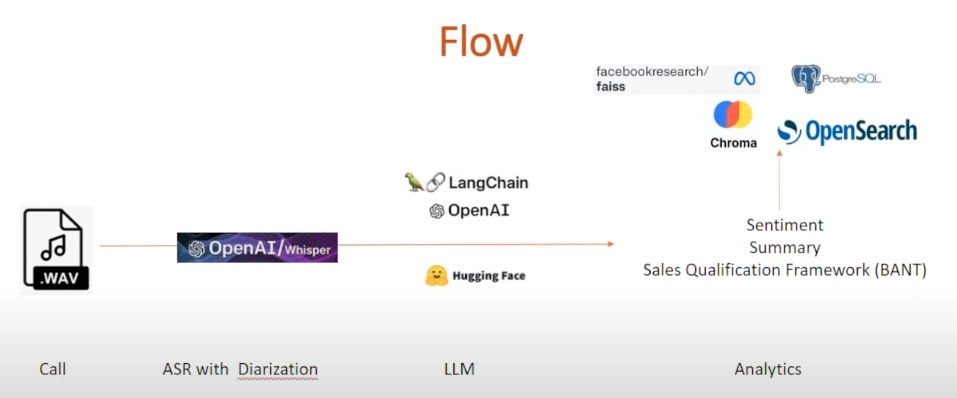

# Load Dependencies

In [7]:
import os
import yaml
import wave
import torch
import openai
import whisper
import datetime
import subprocess
import contextlib
import numpy as np
import pandas as pd
import pyannote.audio
from pyannote.audio import Audio
from pyannote.core import Segment
from sklearn.cluster import AgglomerativeClustering
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [2]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['OPENAI_API_KEY'] = credentials['OPENAI_API_KEY']
os.environ['HUGGINGFACEHUB_API_TOKEN'] = credentials['HUGGINGFACEHUB_API_TOKEN']
os.environ['ENGINE'] = credentials['ENGINE']

openai.api_key = credentials['OPENAI_API_KEY']
openai.api_base = credentials['OPENAI_API_BASE']
openai.api_type = credentials['OPENAI_API_TYPE']
openai.api_version = credentials['OPENAI_API_VERSION']
openai.engine = credentials['ENGINE']

# Methodology
    1. Input is a cenversation between a sales agent and a customer
    2. First we should applu speaker diarization to identify the speaker
    3. Second we should apply speech recognition to convert the speech to text

In [8]:
asr_model = whisper.load_model("large-v2")
embedding_model = PretrainedSpeakerEmbedding(
                                            "speechbrain/spkrec-ecapa-voxceleb",
                                            device = torch.device('mps' if torch.mps.is_available() else 'cpu')
                                            )

 11%|████                                 | 321M/2.87G [13:38<2:29:43, 306kiB/s]

In [3]:
def gpt_turbo_response(
                    system_content,
                    user_content
                    ):
    response = openai.ChatCompletion.create(
                                        engine = os.environ["ENGINE"],
                                        model="gpt-3.5-turbo",
                                        messages=[
                                                {
                                                "role": "system", 
                                                "content": f"{system_content}"
                                                },
                                                {
                                                "role": "user", 
                                                "content": f"{user_content}"
                                                },
                                            ]
                                        )
    
    reply = response.choices[0].message.content.choices[0].message.content
    return reply